![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

The goal of this notebook is to provide clear and thorough data analysis methodology to deal with structural data. In the proposed methodology we will use intuition and common sense to draw conclusions and then test them using statistical tools. Also, we will try to explain statistical results intuitively.

**For the sake of simplifying the notebook, we will only consider numerical variables in our analysis**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Read raw training data
original_data = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')

# Choose only numerical data
numerical_cols = {cname:len(original_data[cname].unique())  for cname in original_data.columns if original_data[cname].dtype in ['int64', 'float64']}
numerical_data = original_data[numerical_cols]
numerical_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## 1. Missing values

Since we don't want to waste your time analysing variables with a lot of missing observations, exploring the missing values seems like a good place to start our analysis.

We should be careful when dealing with missing values. Things to consider are the number of missing values for each variable, and the nature of the values. If the a variable has too little observations (lots of missing values), we would not trust any information it provides about the dependent variable. Otherwise, if we have only a small portion of the observations missing, we could use a suitable technique to replace the missing values.

In [2]:
# Display numerical variables with missing values
total = numerical_data.isnull().sum().sort_values(ascending=False)
percent = (numerical_data.isnull().sum()/numerical_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total']>0]

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479


Luckily only three variables have missing values with a low percentage. A general and safe method is to replace the missing values in each variable with the mean of values in that variable using Imputation.

In [3]:
# Imputation
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
imputed_data = pd.DataFrame(my_imputer.fit_transform(numerical_data))

# Imputation removed column names; put them back
imputed_data.columns = numerical_data.columns
imputed_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


## 2. Correlation matrix 

The Pearson correlation matrix is a great tool to take a first look at your data. It's the best way to start looking for interesting things. It displays the correlation coefficient between any two variables in the dataset. The correlation coefficient takes values between -1 and 1. A value of 1 indicating a very strong positive relation between the two variables, while a value of -1 indicating a very strong negative relation, and a value of 0 indicates no relation.

We are interested in looking into two types of relations:
- First, strong relations between the dependent variable (SalePrice) and the independent variables. A strong relation of this type does not necessary mean causality, since it could be a third hidden variable is causing this relation. However, it means that a particular independent variable has a strong predictive power of the dependent variable, and we can further investigate this relation.

- Second, strong relations between the independent variables. If two independent variables have a strong relation it means that both are giving us the same information, thus we only need to keep one of them. Usually a good practice it to keep the variable with the better relation with the dependent variable.

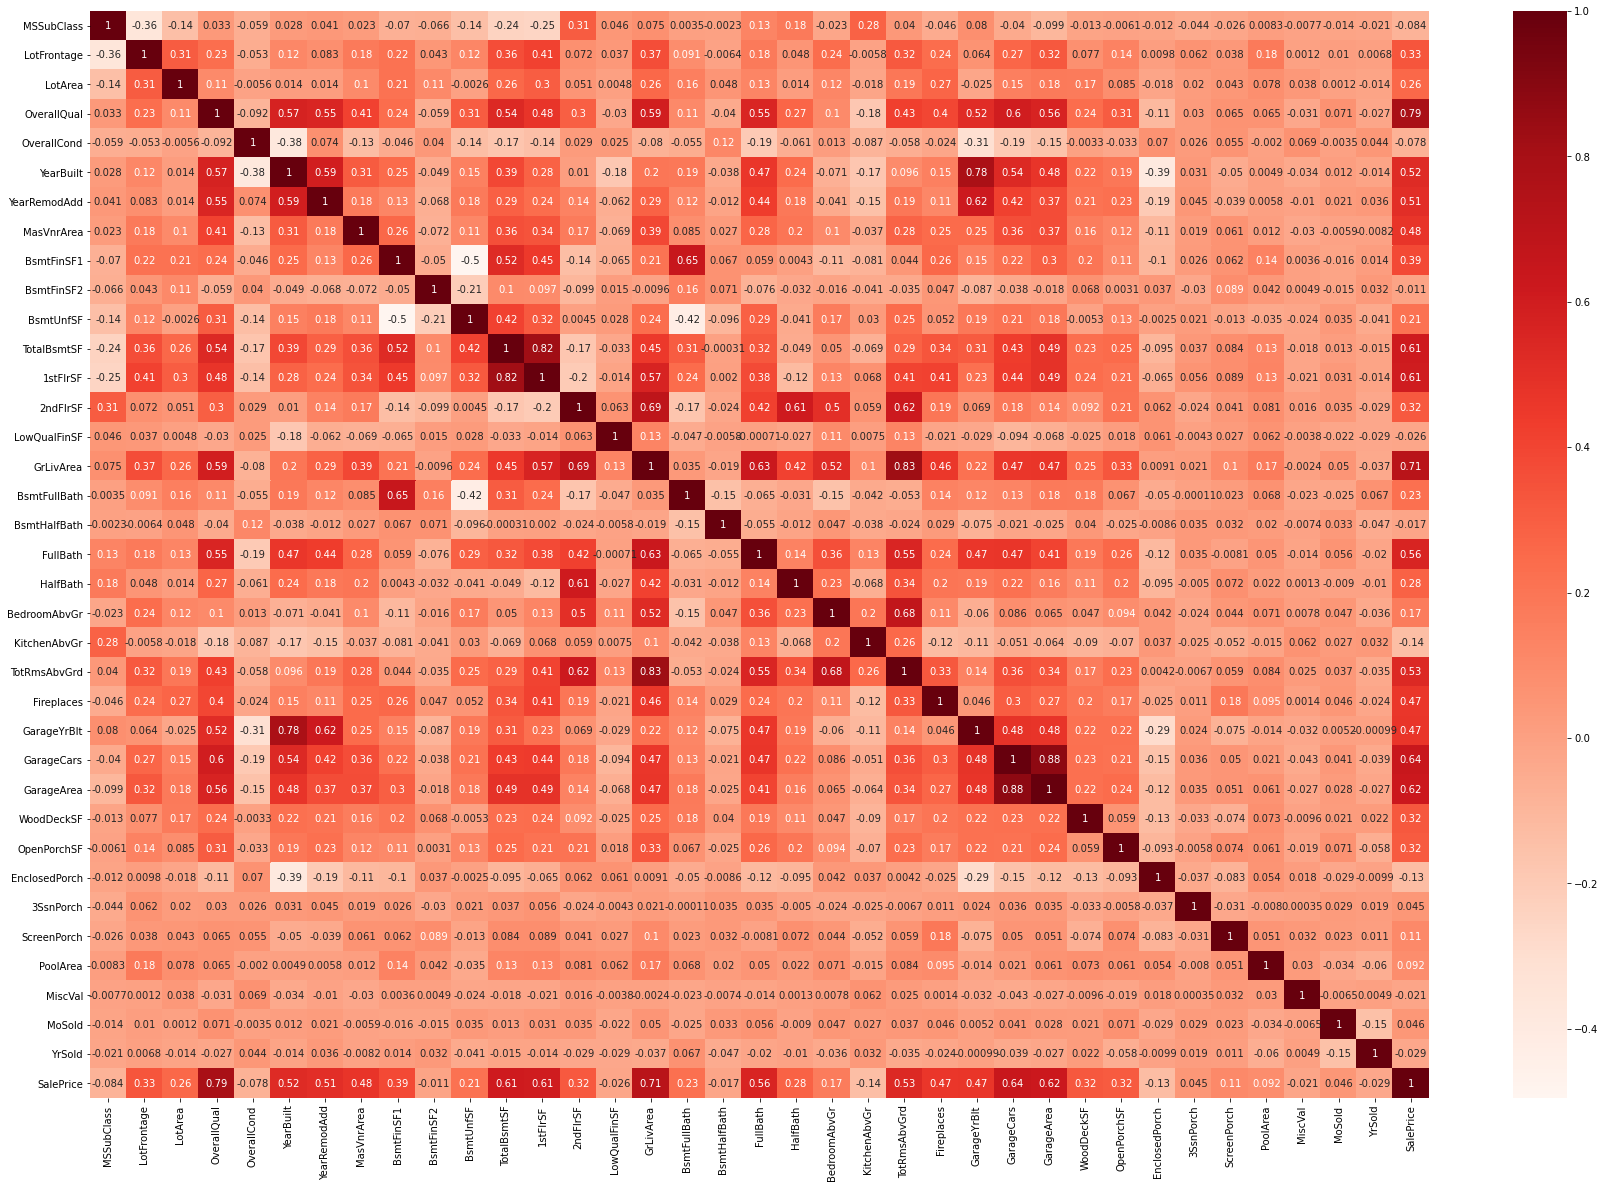

In [4]:
#Display Pearson correlation HeatMap
plt.figure(figsize=(30,20))
cor = imputed_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We already see interesting things happening. The following variables have a strong relation (correlation coefficient >=0.5) with the dependent variable:
- OverallQual
- YearBuilt
- YearRemodAdd
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- FullBath
- TotRmsAbvGrd
- GarageCars
- GarageArea

### Interesting relations to look into

**GarageArea Vs. GarageCars**

We can notice a strong relation (correlation coefficient = 0.88) between the size of the garage in square feet (GaragArea) and the size of the garage in car capacity (GarageCars). It's intuitively clear that both represent the same thing, and that is the size of the garage. We only need to keep GarageCars since it has a higher correlation with the dependent variable.


**TotalBsmtSF Vs. 1stFlrSF**

Another interesting relation between the total square feet of the basement area (TotalBsmtSF) and the first floor square feet (1stFlrSF) with correlation = 0.82. They are basically the same in most houses, and since they have the same correlation with the dependant variable we keep them both for further investigation.

**GrLivArea Vs. TotRmsAbvGrd**

Total rooms above ground (TotRmsAbvGrd) and the above-ground living area square feet (GrLivArea) have a strong correlation, and again they represent the same thing. We only need to keep GrLivArea, can you guess why?


**So far, what variables we will use to build our models?**

To summarize, those are the most interesting variables we found that we will consider in building our models of the problem:

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th></tr>
<tr>
<td>OverallQual</td>
<td>Overall material and finish quality</td>
</tr>
<tr>
<td>YearBuilt</td>
<td>Original construction date</td>
</tr>
<tr>
<td>YearRemodAdd</td>
<td>Remodel date</td>
</tr>
<tr>
<td>TotalBsmtSF</td>
<td>Total square feet of basement area</td>
</tr>
<tr>
<td>1stFlrSF</td>
<td>First Floor square feet</td>
</tr>
<tr>
<td>GrLivArea</td>
<td>Above grade (ground) living area square feet</td>
</tr>
<tr>
<td>FullBath</td>
<td>Full bathrooms above grade</td>
</tr>
<tr>
<td>GarageCars</td>
<td> Size of garage in car capacity</td>
</tr>
<tr>
<td>SalePrice</td>
<td>the property's sale price in dollars. This is the target variable that we're trying to predict.</td>
</tr>
</tbody>
</table>

In [5]:
# Keep only interesting variables, which reduces the dimensionality of the problem
interesting_cols = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', 'SalePrice']
reduced_data = imputed_data[interesting_cols]
reduced_data.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageCars,SalePrice
0,7.0,2003.0,2003.0,856.0,856.0,1710.0,2.0,2.0,208500.0
1,6.0,1976.0,1976.0,1262.0,1262.0,1262.0,2.0,2.0,181500.0
2,7.0,2001.0,2002.0,920.0,920.0,1786.0,2.0,2.0,223500.0
3,7.0,1915.0,1970.0,756.0,961.0,1717.0,1.0,3.0,140000.0
4,8.0,2000.0,2000.0,1145.0,1145.0,2198.0,2.0,3.0,250000.0


## 3. Scatter plot

Scatter plots are the best tool to look for trends in the dataset. The correlation matrix told us which variables are worth looking into, and now we want to see a visualization of the interesting things happening between the selected variables.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


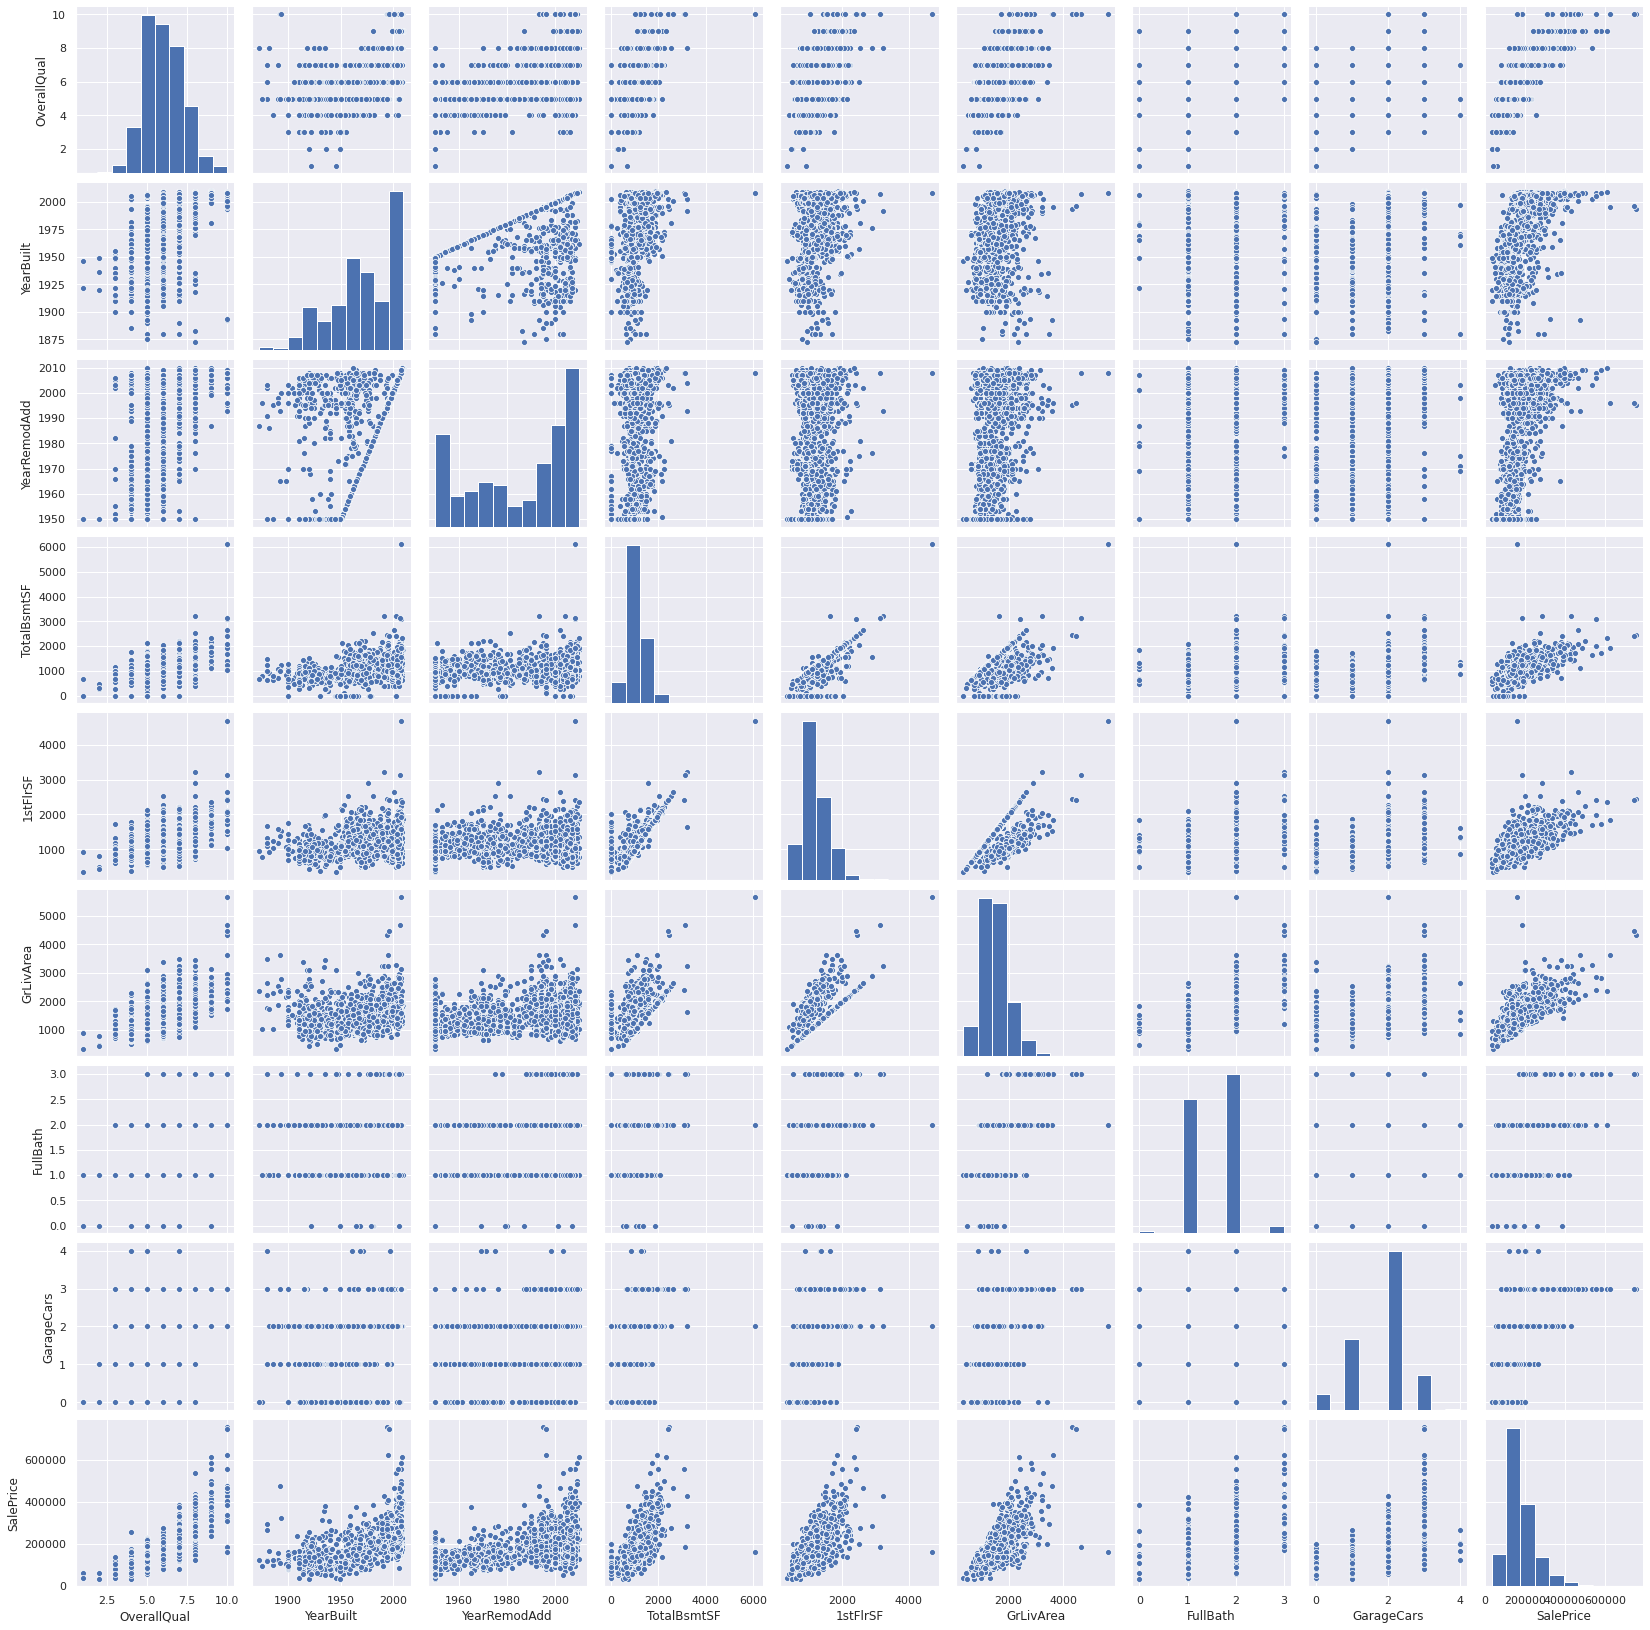

In [6]:
#scatterplot
sns.set()
sns.pairplot(reduced_data, size = 2.5)
plt.show();

Let's start by looking into the two controversial variables from the last step, namely, TotalBsmtSF and 1stFlrSF. As expected, they both have a clear trend with the dependent variable (SalePrice). However, we can see that TotalBsmtSF has a set of observations with a value of zero, which means that those houses do not have a basement, and the variable 1stFlrSF does not suffer from this issue. Since both variables provide us with the same information, we will keep 1stFlrSF so we do not face troubles when transforming zero observations in the next steps (It will make sense soon).

An interesting scatterplot to look at is the one between 1stFlrSF on the x-axis and GrLivArea on the y-axis. We can see dots forming a straight line, and this line is where 1stFlrSF = GrLivArea. No dots are below that line because the living area above ground is always equal or bigger than the area of the first floor.

### outliers!
We are mainly interested here in studying trends between the independent variables and the dependent variable, and we can see that all independent variables have a clear trend with the dependent variable, which explains the strong correlation between them. However, we can see a few observations in 1stFlrSF and GrLivArea do not follow the main trend, which could be meant that we got outliers. Outliers are extreme values in our observations that could be harmful or could carry useful information, so we need to look further into them.

Let's first plot 1stFlrSF against SalePrice with regression line

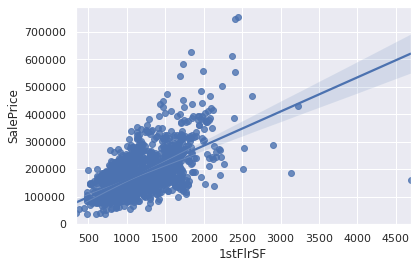

In [7]:
sns.regplot(x=reduced_data['1stFlrSF'], y=reduced_data['SalePrice'])

Now let's plot 1stFlrSF against SalePrice without the extreme values (1stFlrSF > 4000 and low price)

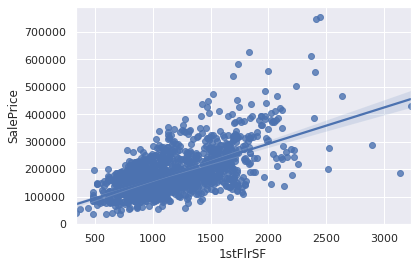

In [8]:
sns.regplot(x=reduced_data[reduced_data['1stFlrSF']<4000]['1stFlrSF'], y=reduced_data[reduced_data['1stFlrSF']<4000]['SalePrice'])

The extreme values represents houses with large areas and low prices, and this could be explained by assuming they are located in agricultural areas. And since we can identify only one datapoint with a First Floor area larger than 4000, we will delete it.  

In [9]:

interesting_cols = ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', 'SalePrice']

reduced_data = reduced_data[reduced_data['1stFlrSF']<4000][interesting_cols]
reduced_data = reduced_data[interesting_cols]
reduced_data.head()

,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,GarageCars,SalePrice
0,7.0,2003.0,2003.0,856.0,1710.0,2.0,2.0,208500.0
1,6.0,1976.0,1976.0,1262.0,1262.0,2.0,2.0,181500.0
2,7.0,2001.0,2002.0,920.0,1786.0,2.0,2.0,223500.0
3,7.0,1915.0,1970.0,961.0,1717.0,1.0,3.0,140000.0
4,8.0,2000.0,2000.0,1145.0,2198.0,2.0,3.0,250000.0


## 4. Normality 

Finally, we want to investigate an important statistical property of the data, which is normality. It means that data should follow a normal distribution, and we are interested in normal distributions because it has some nice properties like its symmetry.

Let's start by investigating the dependent (target) variable SalePrice.
We will do that using two methods:
- **Histogram** - Kurtosis and skewness.
- **Normal probability plot** - Data distribution should closely follow the diagonal that represents the normal distribution.

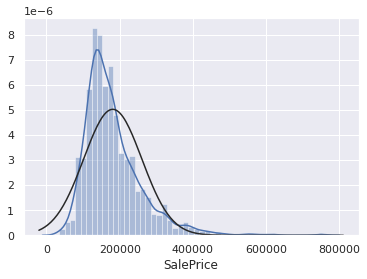

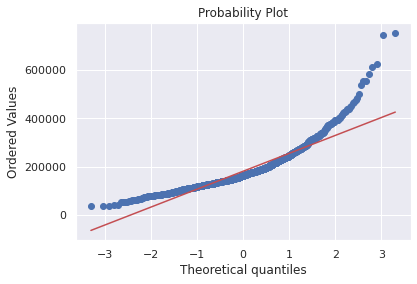

In [10]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(reduced_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['SalePrice'], plot=plt)

Right away we can see that SalePrice does not follow a normal distribution and has positive skewness, but luckily we know a simple solution for that, we can simply take the log transformations. 

In [11]:
#applying log transformation
reduced_data['SalePrice'] = np.log(reduced_data['SalePrice'])

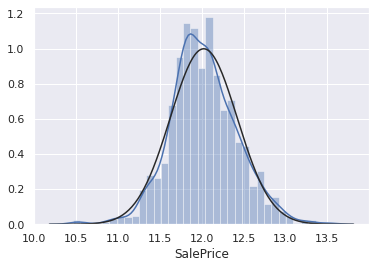

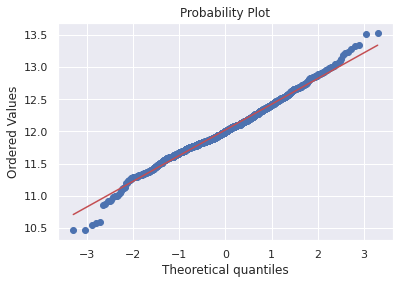

In [12]:
#histogram and normal probability plot
sns.distplot(reduced_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['SalePrice'], plot=plt)

That looks great! As expected, now it has a normal distribution, and all points fall on the diagonal line!


Now let's try this on GrLivArea and 1stFlrSF

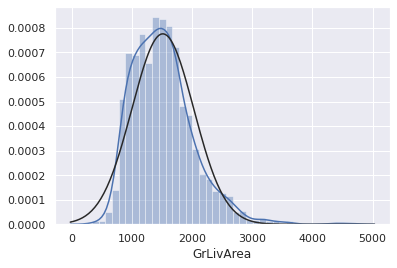

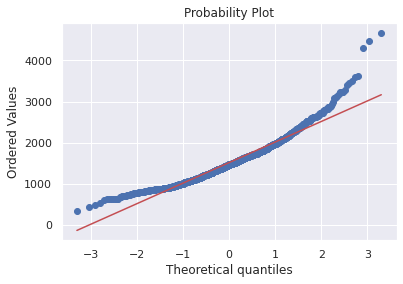

In [13]:
#histogram and normal probability plot
sns.distplot(reduced_data['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['GrLivArea'], plot=plt)

In [14]:
#applying log transformation
reduced_data['GrLivArea'] = np.log(reduced_data['GrLivArea'])

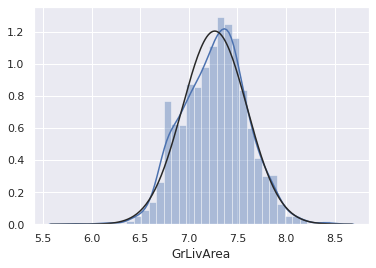

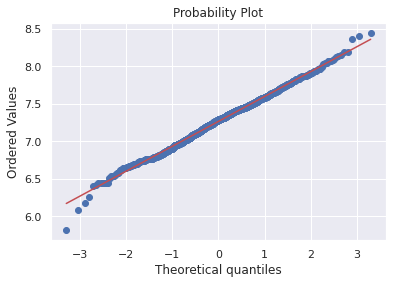

In [15]:
#histogram and normal probability plot
sns.distplot(reduced_data['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['GrLivArea'], plot=plt)

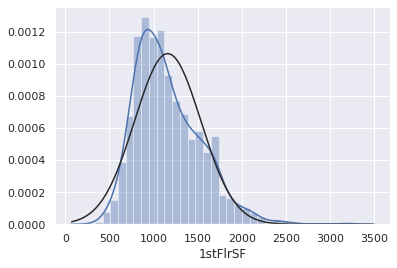

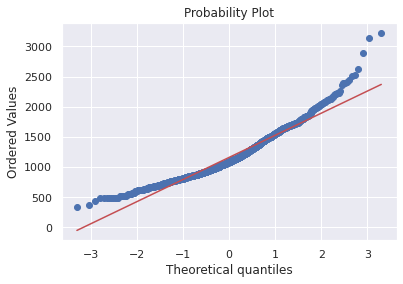

In [16]:
#histogram and normal probability plot
sns.distplot(reduced_data['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['1stFlrSF'], plot=plt)

In [17]:
#applying log transformation
reduced_data['1stFlrSF'] = np.log(reduced_data['1stFlrSF'])

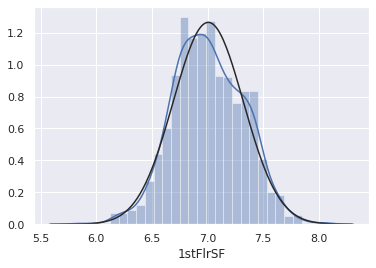

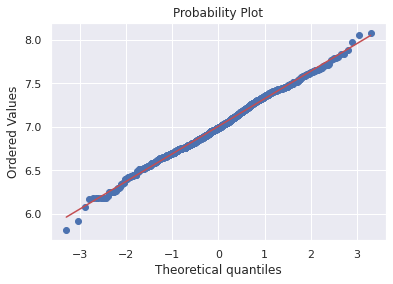

In [18]:
#histogram and normal probability plot
sns.distplot(reduced_data['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(reduced_data['1stFlrSF'], plot=plt)

## 5. What next?

Now after this thorough analysis we've identified the most influential variables in predicting the behavior of the target variable SalePrice, and now what left is for you to use them to build a machine learning model of your choice that predicts house prices!